In [1]:
import sys, os, json, math, re
sys.path.append('backend/app/')
import xarray as xr, numpy as np, geopandas as gpd
import pandas as pd
from Functions import functions
from scipy.interpolate import Rbf, griddata, interp1d
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import distance_transform_edt, gaussian_filter
from shapely.geometry import Polygon
from meshkernel import MeshKernel, GeometryList
import dfm_tools as dfmt

In [2]:
def remove_holes(geom, cell_size=0):
    geom = geom.buffer(0)
    if geom.geom_type != "Polygon": return geom
    kept_interiors = [ ring for ring in geom.interiors
        if Polygon(ring).area >= cell_size
    ]
    return Polygon(geom.exterior, kept_interiors)

c:\Envs\delft3d\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: Several features with id = 317 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


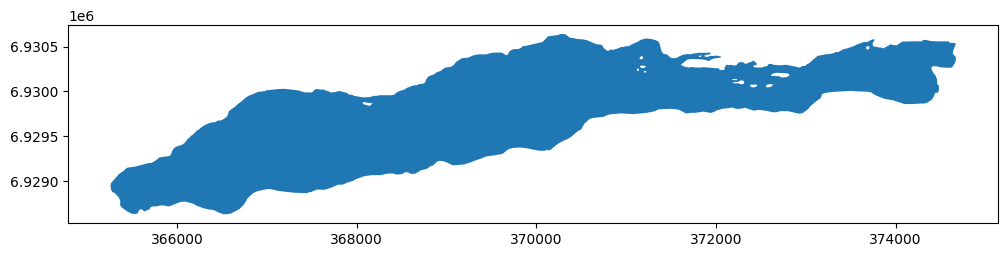

In [3]:
lake, depth = gpd.read_file('lake.geojson'), gpd.read_file('depth.geojson')
lake["geometry"] = lake.geometry.apply(lambda geo: remove_holes(geo, 0))
fig, ax = plt.subplots(figsize=(12, 10))
lake.plot(ax=ax)
plt.show()

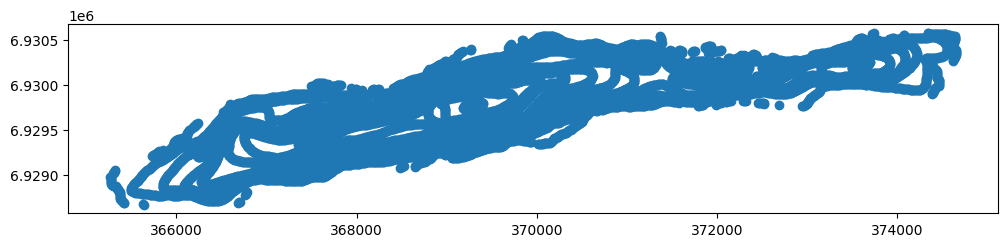

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))
depth.plot(ax=ax)
plt.show()

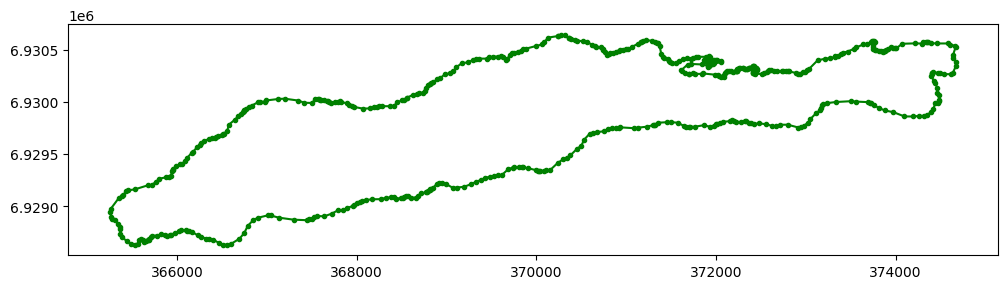

In [5]:
x, y = lake.geometry.iloc[0].exterior.xy
x, y = np.array(x), np.array(y)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, y, ".-", color="green")
plt.show()

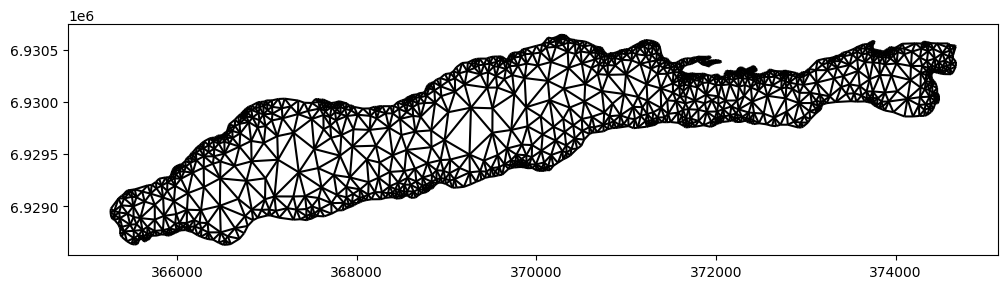

In [38]:
polygon = GeometryList(x, y)
mk = MeshKernel()
mk.mesh2d_make_triangular_mesh_from_polygon(polygon)
mesh = mk.mesh2d_get()
fig, ax = plt.subplots(figsize=(12, 3))
mesh.plot_edges(ax, color="black")
plt.show()

In [39]:
node_x, node_y = mesh.node_x, mesh.node_y
grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(node_x, node_y), crs=lake.crs)
node_z = functions.interpolation_Z(grid, depth["geometry"].x, depth["geometry"].y, depth["depth"].values, n_neighbors=2, geo_type='point')

In [45]:
[k for k in dir(mesh)]

['Property',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'almost_equal',
 'edge_faces',
 'edge_nodes',
 'edge_x',
 'edge_y',
 'face_edges',
 'face_nodes',
 'face_x',
 'face_y',
 'node_x',
 'node_y',
 'nodes_per_face',
 'plot_edges',
 'plot_faces',
 'remove_invalid_values',
 'valid_edges_map',
 'valid_faces_map',
 'valid_nodes_map']

In [122]:
mesh.edge_faces.shape, mesh.edge_nodes.shape, mesh.face_edges.shape, mesh.face_nodes.shape

((4118,), (8236,), (2548,), (7645,))

In [125]:
mesh.face_x.shape, mesh.face_y.shape

((2548,), (2548,))

In [128]:
mesh.edge_faces

array([775, 776, 775, ...,   2,   8,  -1])

In [130]:
edge_faces = np.full((mesh.face_x.shape[0], 2), np.nan)
n = 0
for i in range(mesh.face_x.shape[0]):
    edge_faces[i, 0] = mesh.edge_faces[n]
    n += 1
    edge_faces[i, 1] = mesh.edge_faces[n]
    if i < len(mesh.edge_faces) and mesh.edge_faces[i] != -1:
        edge_faces[i, 1] = mesh.edge_faces[i]
        n += 1

IndexError: index 4118 is out of bounds for axis 0 with size 4118

In [136]:
face_nodes

array([[0.000e+00, 5.560e+02, 1.001e+03,       nan],
       [0.000e+00, 1.001e+03, 8.520e+02,       nan],
       [0.000e+00, 8.520e+02, 1.000e+00,       nan],
       ...,
       [1.555e+03, 1.562e+03, 1.563e+03,       nan],
       [1.557e+03, 1.564e+03, 1.565e+03,       nan],
       [4.800e+01, 9.020e+02, 7.330e+02, 7.180e+02]])

In [156]:
# Convert to Ugrid
grid_uds = dfmt.meshkernel_to_UgridDataset(mk, crs=lake.crs)
grid_uds['mesh2d_node_z'] = (("mesh2d_nNodes",), node_z.astype('float64'))
grid_uds['mesh2d_edge_x'] = (("mesh2d_nEdges",), mesh.edge_x)
grid_uds['mesh2d_edge_y'] = (("mesh2d_nEdges",), mesh.edge_y)
# Make mesh2d_edge_nodes
edge_nodes = mesh.edge_nodes.reshape((mesh.edge_x.size, 2))
grid_uds['mesh2d_edge_nodes'] = (("mesh2d_nEdges", "Two"), edge_nodes)
# Make mesh2d_face_nodes
face_nodes = np.full((mesh.nodes_per_face.shape[0], max(mesh.nodes_per_face)), np.nan)
offset = np.zeros_like(mesh.nodes_per_face)
offset[1:] = np.cumsum(mesh.nodes_per_face[:-1])
for i in range(mesh.nodes_per_face.shape[0]):
    n = mesh.nodes_per_face[i]
    face_nodes[i, :n] = mesh.face_nodes[offset[i]:offset[i] + n]
grid_uds['mesh2d_face_nodes'] = (("mesh2d_nFaces", "mesh2d_nMax_face_nodes"), face_nodes)
# Make mesh2d_edge_faces

# grid_uds['mesh2d_edge_faces'] = (("mesh2d_nEdges", "Two"), edge_faces)
grid_uds['mesh2d_face_x'] = (("mesh2d_nFaces",), mesh.face_x)
grid_uds['mesh2d_face_y'] = (("mesh2d_nFaces",), mesh.face_y)
# Make mesh2d_face_x_bnd, mesh2d_face_y_bnd
x_bnd, y_bnd = [], []
for i in range(mesh.nodes_per_face.shape[0]):
    x = [mesh.face_x[int(x)] if np.isnan(x) == False else np.nan for x in face_nodes[i]]
    y = [mesh.face_y[int(x)] if np.isnan(x) == False else np.nan for x in face_nodes[i]]
    x_bnd.append(x); y_bnd.append(y)
x_bnd, y_bnd = np.array(x_bnd, dtype=np.float64), np.array(y_bnd, dtype=np.float64)
grid_uds['mesh2d_face_x_bnd'] = (("mesh2d_nFaces", "mesh2d_nMax_face_nodes"), x_bnd)
grid_uds['mesh2d_face_y_bnd'] = (("mesh2d_nFaces", "mesh2d_nMax_face_nodes"), y_bnd)

# # Write to NetCDF
# grid_uds.to_netcdf("net.nc")
grid_uds

<xarray.Dataset> Size: 434kB
Dimensions:                      (mesh2d_nNodes: 1571, mesh2d_nEdges: 4118,
                                  Two: 2, mesh2d_nFaces: 2548,
                                  mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 13kB 3.704e+05 ... 3...
    mesh2d_node_y                (mesh2d_nNodes) float64 13kB 6.931e+06 ... 6...
  * mesh2d_nNodes                (mesh2d_nNodes) int64 13kB 0 1 2 ... 1569 1570
Dimensions without coordinates: mesh2d_nEdges, Two, mesh2d_nFaces,
                                mesh2d_nMax_face_nodes
Data variables:
    projected_coordinate_system  int32 4B -2147483647
    mesh2d_node_z                (mesh2d_nNodes) float64 13kB -10.0 ... -70.0
    mesh2d_edge_x                (mesh2d_nEdges) float64 33kB 3.655e+05 ... 3...
    mesh2d_edge_y                (mesh2d_nEdges) float64 33kB 6.929e+06 ... 6...
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 33kB 415 ... 194
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 20kB 3.703e+05 ... 3...
    mesh2d_face_y                (mesh2d_nFaces) float64 20kB 6.931e+06 ... 6...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
Attributes:
    Conventions:  CF-1.9 UGRID-1.0
    institution:  Deltares
    references:   https://www.deltares.nl
    source:       Created with meshkernel 8.2.2, xugrid 0.14.3 and dfm_tools ...
    history:      Created on 2026-02-09T23:10:13, vanln

In [157]:
grid_uds['mesh2d_face_x_bnd'].values.shape, grid_uds['mesh2d_face_x_bnd'].values

((2548, 4),
 array([[370337.67492667, 370763.97419671, 369548.59704077,
                     nan],
        [370337.67492667, 369548.59704077, 366463.43443742,
                     nan],
        [370337.67492667, 366463.43443742, 370348.68962675,
                     nan],
        ...,
        [366868.87750998, 372910.68168962, 373105.75447416,
                     nan],
        [373800.58818166, 373133.66069707, 373106.68653788,
                     nan],
        [371182.05546755, 367320.86320693, 366128.24168023,
         366562.32498316]]))

In [12]:
data = xr.open_dataset(r'backend\static\samples\grid\Grid_net.nc')
data

<xarray.Dataset> Size: 919kB
Dimensions:            (mesh2d_nNodes: 2645, mesh2d_nEdges: 7579, Two: 2,
                        mesh2d_nFaces: 4935, mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x      (mesh2d_nNodes) float64 21kB ...
    mesh2d_node_y      (mesh2d_nNodes) float64 21kB ...
Dimensions without coordinates: mesh2d_nNodes, mesh2d_nEdges, Two,
                                mesh2d_nFaces, mesh2d_nMax_face_nodes
Data variables:
    wgs84              int32 4B ...
    mesh2d             int32 4B ...
    mesh2d_node_z      (mesh2d_nNodes) float64 21kB ...
    mesh2d_edge_x      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_y      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_nodes  (mesh2d_nEdges, Two) int32 61kB ...
    mesh2d_face_nodes  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_edge_faces  (mesh2d_nEdges, Two) float64 121kB ...
    mesh2d_face_x      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_y      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_x_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_face_y_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
Attributes:
    institution:  Deltares
    references:   http://www.deltares.nl
    source:       RGFGRID 7.03.00.77422. Model: ---
    history:      Created on 2024-09-06T11:08:32+0200, RGFGRID
    Conventions:  CF-1.8 UGRID-1.0 Deltares-0.10

In [158]:
data['mesh2d_edge_faces'].values.shape, data['mesh2d_edge_faces'].values

((7579, 2),
 array([[  50.,    0.],
        [  50.,   54.],
        [  50.,   51.],
        ...,
        [4894., 4923.],
        [4347., 4636.],
        [4655., 4656.]]))

In [135]:
data['mesh2d_face_nodes'].values.shape, data['mesh2d_face_nodes'].values

((4935, 4),
 array([[1.000e+00, 2.000e+00, 7.060e+02,       nan],
        [1.000e+00, 7.060e+02, 6.860e+02,       nan],
        [1.000e+00, 6.860e+02, 3.520e+02,       nan],
        ...,
        [2.634e+03, 2.638e+03, 2.635e+03,       nan],
        [2.641e+03, 2.643e+03, 2.645e+03,       nan],
        [1.423e+03, 1.425e+03, 1.426e+03, 1.657e+03]]))

In [26]:
data['mesh2d_face_x'].values.shape, data['mesh2d_face_y'].values.shape, data['mesh2d_face_nodes'].values.shape

((4935,), (4935,), (4935, 4))

In [61]:
is_hyd = key == 'hyd'
data_ds = hyd_map if is_hyd else waq_map
layer_path = r'backend\Delft_Projects\demo\output\config\layers_hyd.json'
if '_waq_multi_dynamic' in query: query = 'mesh2d_' + query[:-len('_waq_multi_dynamic')]
name = functions.variablesNames.get(query, query)
values, fnm = data_ds[name].values, functions.numberFormatter
layer_reverse = json.load(open(layer_path))
with open(r'points.json', 'r') as f:
    points = json.load(f)
depth_values = [float(v.split(' ')[1]) for k, v in layer_reverse.items() if int(k) >= 0]
max_layer = float(max(np.array(depth_values), key=abs))
n_rows = math.ceil(abs(max_layer)/10)*10 + 1 if max_layer < 0 else -(math.ceil(abs(max_layer)/10)*10 + 1)
mesh_cache = { "depth_values": depth_values, "n_rows": n_rows, "df": None}
time_column = 'time' if is_hyd else 'nTimesDlwq'
time_stamps = pd.to_datetime(data_ds[time_column]).strftime('%Y-%m-%d %H:%M:%S').tolist()
arr = values[-1,:,:] if is_hyd else values[-1,:,:].T
# Create GeoDataFrame for interpolation
points_arr, grid = np.array(points), functions.unstructuredGridCreator(hyd_map)
x_coords, y_coords = points_arr[:, 2], points_arr[:, 1]
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_coords, y_coords), crs=grid.crs)
gdf['depth'] = functions.interpolation_Z(gdf, hyd_map['mesh2d_node_x'].values, 
    hyd_map['mesh2d_node_y'].values, hyd_map['mesh2d_node_z'].values)
# Find polygons that the points are in
gdf_filtered = gpd.sjoin(gdf, grid, how="left", predicate="intersects")
gdf_filtered.set_index('index_right', inplace=True)
df_serialized = gdf_filtered.drop(columns=['geometry'])
mesh_cache["df"] = df_serialized.to_dict(orient='split')

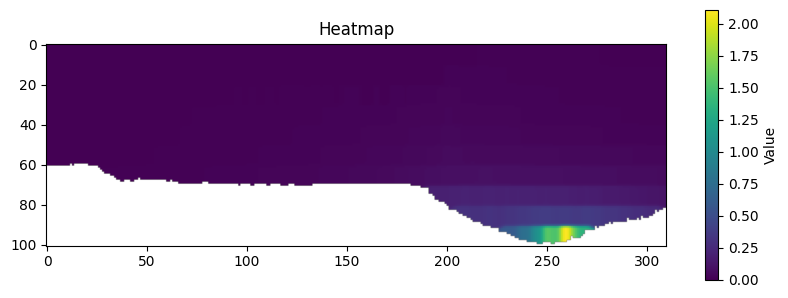

In [62]:
cache_copy = mesh_cache.copy()
data = cache_copy["df"]
df = pd.DataFrame(data=data["data"], columns=data["columns"], index=data["index"])
df_depth = np.array(df["depth"].values, dtype=float)
df_depth_rounded, n_rows = abs(np.round(df_depth, 0)), cache_copy["n_rows"]
depth_values = np.array(cache_copy["depth_values"], dtype=float)
depth_rounded = abs(np.round(depth_values, 0))
index_map = {int(v): len(depth_rounded)-i-1 for i, v in enumerate(depth_rounded)}
# Pre-allocate frame
frame = np.full((len(df), abs(n_rows)), np.nan, float)
values_filtered = arr[df.index.values, :]
depth_int = depth_rounded.astype(int)
valid_depth = np.unique(depth_int[depth_int < abs(n_rows)])
col_idx = np.array([index_map[d] for d in valid_depth])
mask = df_depth[:, None] <= -valid_depth[None, :]
vals = values_filtered[:, col_idx]
frame[:, valid_depth] = np.where(mask, vals, frame[:, valid_depth])

# Interpolate and fill missing values row-wise
mask = ~np.isnan(frame)
_, (ix, iy) = distance_transform_edt(~mask, return_indices=True)
frame_filled = gaussian_filter(frame[ix, iy], sigma=(1.2, 0.6))
frame = np.clip(frame_filled, 0, None)


mask_valid = -np.arange(abs(n_rows))[None, :] >= df_depth[:, None]
max_row = np.max(np.where(mask_valid.T)[0])
frame[~mask_valid] = np.nan
smoothed_transpose = frame.T[:max_row + 2, :]

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(smoothed_transpose, origin='lower', cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Value')
plt.title('Heatmap')
plt.show()